In [1]:
import sys 
sys.path.append("..")


In [2]:
from PIL import Image as im
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from src.utils.config import Config
from src.models.ae.ae import Autoencoder
from src.models.random.random import RandomModel
from src.eval import eval_swirl_mask
from src.dataset import load_flowers_dataset, FlowersDataset, SwirledDataset, inv_preprocess_img, preprocess_img

In [3]:
data, labels = load_flowers_dataset('../data/flower_photos')
ds = FlowersDataset(data)
ds_swirled = SwirledDataset(data, STRENGTH=4)

dl = DataLoader(ds, batch_size=16, shuffle=True)
dl_swirled = DataLoader(ds_swirled, batch_size=16, shuffle=True)

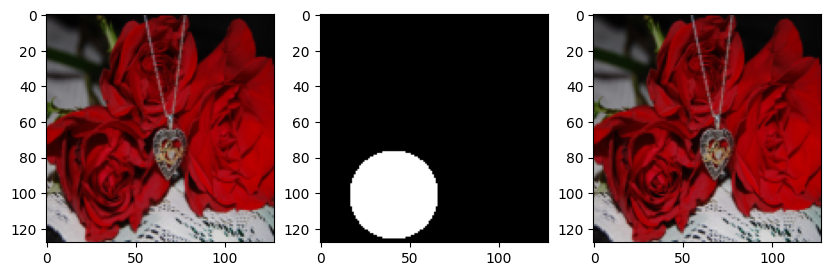

In [4]:
simg, mask, oimg = ds_swirled[10]

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(
    inv_preprocess_img(simg)
)

plt.subplot(1, 3, 2)
plt.imshow(
    inv_preprocess_img(mask),
    cmap='gray'
)

plt.subplot(1, 3, 3)
plt.imshow(
    inv_preprocess_img(oimg)
)

In [6]:
ae = Autoencoder(hidden_dim=512)
ae.load_state_dict(
    torch.load(
        '../logs/autoencoder.pth',
        map_location=torch.device('cpu')
    )
)

summary(ae, (3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
         LeakyReLU-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 32, 32, 32]           4,640
         LeakyReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
         LeakyReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
         LeakyReLU-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 4, 4]         295,168
        LeakyReLU-10            [-1, 256, 4, 4]               0
           Linear-11                  [-1, 512]       2,097,664
           Linear-12                 [-1, 4096]       2,101,248
  ConvTranspose2d-13            [-1, 128, 8, 8]         295,040
        LeakyReLU-14            [-1, 12

In [6]:
# model = Autoencoder(hidden_dim=512).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

#model = ae.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

model = RandomModel().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

eval_swirl_mask(
    dl_swirled,
    model
)

/home/leo/docs/swirl_exp/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


{'mse_ratio:': 30.803373336791992}

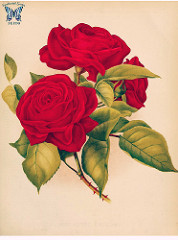

In [ ]:
data[0]

In [4]:
type(data[0])

PIL.JpegImagePlugin.JpegImageFile

In [12]:
isinstance(data[0], im.Image)

True

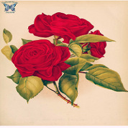

In [4]:
data[0].resize((128, 128))

In [6]:
import numpy as np
np.array(data[0]).shape

(240, 178, 3)

In [8]:
m= 99999
for i in data:
    i = np.array(i)
    m_new = min(i.shape[0], i.shape[1])
    if m_new < m:
        m = m_new

In [9]:
m

143

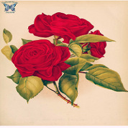

In [ ]:
from src.dataset import preprocess_img

im.fromarray(
    preprocess_img(
        data[0], 
        normalize=False
    )
)

In [ ]:
from models.ae.ae import Autoencoder
import torch

ae = Autoencoder(hidden_dim=512)
ae.load_state_dict(
    torch.load(
        '../logs/autoencoder.pth',
        map_location=torch.device('cpu')
    )
)

<All keys matched successfully>

In [83]:
import numpy as np
from PIL import Image as im

in_batch = next(iter(dl))
out_batch = ae(in_batch)[0]

idx = 0


# im.fromarray(
#     (ae(in_batch)[0][0]*255).int().detach().numpy().transpose(1, 2, 0).astype(np.uint8)
# )

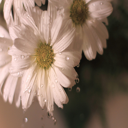

In [84]:
im.fromarray((in_batch[idx]*255).detach().numpy().transpose(1, 2, 0).astype(np.uint8))

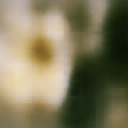

In [85]:
im.fromarray((out_batch[idx]*255).detach().numpy().transpose(1, 2, 0).astype(np.uint8))

## ResNet

In [4]:
from src.models.resnet.resnet import ResNet

resnet = ResNet(
    block_dims=[3, 8, 3]
)
summary(resnet, (3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
       BatchNorm2d-2          [-1, 8, 128, 128]              16
         LeakyReLU-3          [-1, 8, 128, 128]               0
            Conv2d-4          [-1, 8, 128, 128]             584
       BatchNorm2d-5          [-1, 8, 128, 128]              16
            Conv2d-6          [-1, 8, 128, 128]              32
         LeakyReLU-7          [-1, 8, 128, 128]               0
       ResNetBlock-8          [-1, 8, 128, 128]               0
            Conv2d-9          [-1, 3, 128, 128]             219
      BatchNorm2d-10          [-1, 3, 128, 128]               6
          Sigmoid-11          [-1, 3, 128, 128]               0
           Conv2d-12          [-1, 3, 128, 128]              84
      BatchNorm2d-13          [-1, 3, 128, 128]               6
           Conv2d-14          [-1, 3, 1

In [5]:
#load checkpoint

log_dir = '../logs/ResNet/v16/'

hparams = Config.from_yaml(log_dir + 'hparams.yaml')

checkpoint = torch.load(
    log_dir + 'checkpoints/step_2300.pt',
    map_location=torch.device('cpu')
)

resnet = ResNet(
    block_dims=hparams.model_params['block_dims']
)
resnet.load_state_dict(checkpoint['model'])
resnet.eval()

ResNet(
  (layers): ModuleList(
    (0): ResNetBlock(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (convadapter): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (1): ResNetBlock(
      (conv1): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (convadapter): Conv2d(16, 3, kernel_size=(1, 1), stride=(1, 1))
      (ac

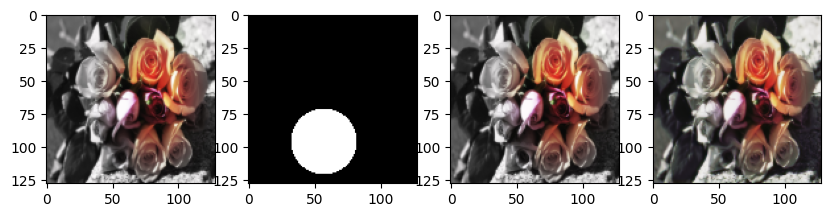

In [11]:
simg, mask, oimg = ds_swirled[17]

plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(
    inv_preprocess_img(
        simg,
        denormalize=False
    )
)

plt.subplot(1, 4, 2)
plt.imshow(
    inv_preprocess_img(mask),
    cmap='gray'
)

plt.subplot(1, 4, 3)
plt.imshow(
    inv_preprocess_img(
        oimg,
        denormalize=False
    )
)

plt.subplot(1, 4, 4)
plt.imshow(
    inv_preprocess_img(
        resnet(simg.unsqueeze(0)).squeeze(0),
        denormalize=False
    )
)

# plt.subplot(1, 4, 4)
# plt.imshow(
#     np.random.rand(128, 128, 3)  # Placeholder for model output
# )

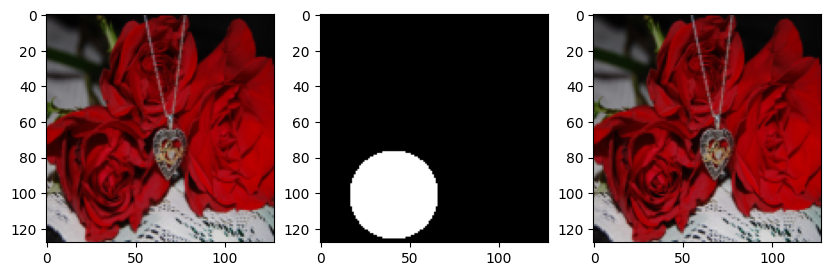

In [ ]:
simg, mask, oimg = ds_swirled[10]

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(
    inv_preprocess_img(simg)
)

plt.subplot(1, 3, 2)
plt.imshow(
    inv_preprocess_img(mask),
    cmap='gray'
)

plt.subplot(1, 3, 3)
plt.imshow(
    inv_preprocess_img(oimg)
)